In [1]:
%load_ext autoreload

In [2]:
#load in modules
%autoreload 2
from wildfireassessment.ops import * #my package
import rasterio
from rasterio.transform import xy
from rasterio.plot import show, show_hist
from rasterio.mask import mask
import matplotlib.pyplot as plt
from pathlib import Path
import os
import earthpy as et
import earthpy.plot as ep
import numpy as np
import geopandas as gpd
from fiona.crs import from_epsg
from pyproj import Proj, transform
from functools import partial
import pyproj
from shapely.ops import transform
from rasterstats import zonal_stats
import itertools
%matplotlib inline
# from osgeo import gdal, osr, ogr, gdal_array
# from osgeo.gdalconst import *

# Load WorldView images that are clipped to AOI

In [3]:
#read in filepaths for data

filepath_post = Path("./data/Paradise/post")
filepath_pre = Path("./data/Paradise/pre")

#WorldView Post/Pre
fps_wv_post = list(filepath_post.glob("2*_clip.tif"))
fps_wv_pre = list(filepath_pre.glob("2*_clip.tif"))

#Sent2 Post/Pre
fp_sent2_post = filepath_post / "B08_post_clipped_byte_scaled.tif"
fp_sent2_pre = filepath_pre / "B08_pre_clipped_byte_scaled.tif"

In [7]:
raster_src_post, rgb_post = readRGBImg(fps_wv_post[0])
raster_src_pre, rgb_pre = readRGBImg(fps_wv_pre[0])

In [6]:
raster_src_post_b08, b08_post = readOneImg(fp_sent2_post)
raster_src_pre_b08, b08_pre = readOneImg(fp_sent2_pre)

In [7]:
!gdalinfo data/Paradise/post/B08_post_clipped_byte_scaled.tif

Driver: GTiff/GeoTIFF
Files: data/Paradise/post/B08_post_clipped_byte_scaled.tif
Size is 1490, 2279
Coordinate System is:
PROJCS["WGS 84 / UTM zone 10N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-123],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32610"]]
Origin = (612620.000000000000000,4413130.000000000000000)
Pixel Size = (10.000000000000000,-10.00000000000000

# Clipped images

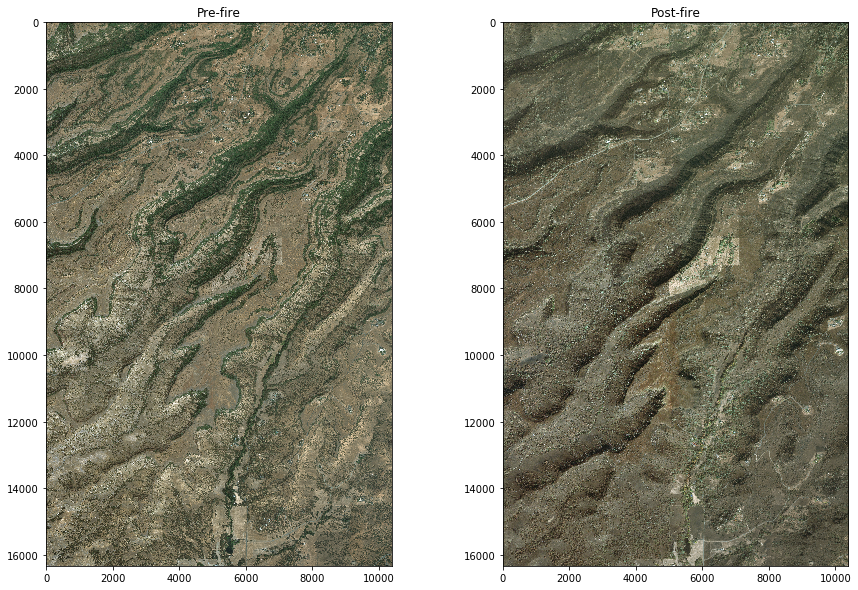

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 10))
im = ax1.imshow(rgb_pre)
ax1.set_title("Pre-fire")
im = ax2.imshow(rgb_post)
ax2.set_title("Post-fire")
plt.show()

In [10]:
x_r_pre = rgb_pre[:,:,0].ravel().reshape(-1, 1)
x_g_pre = rgb_pre[:,:,1].ravel().reshape(-1, 1)
x_b_pre = rgb_pre[:,:,2].ravel().reshape(-1, 1)
x_pre = np.hstack((x_r_pre, x_g_pre, x_b_pre))
x_r_pre, x_g_pre, x_b_pre = None, None, None

y_r_post = rgb_post[:,:,0].ravel().reshape(-1, 1)
y_g_post = rgb_post[:,:,1].ravel().reshape(-1, 1)
y_b_post = rgb_post[:,:,2].ravel().reshape(-1, 1)
y_post = np.hstack((y_r_post, y_g_post, y_b_post))
y_r_post, y_g_post, y_b_post = None, None, None

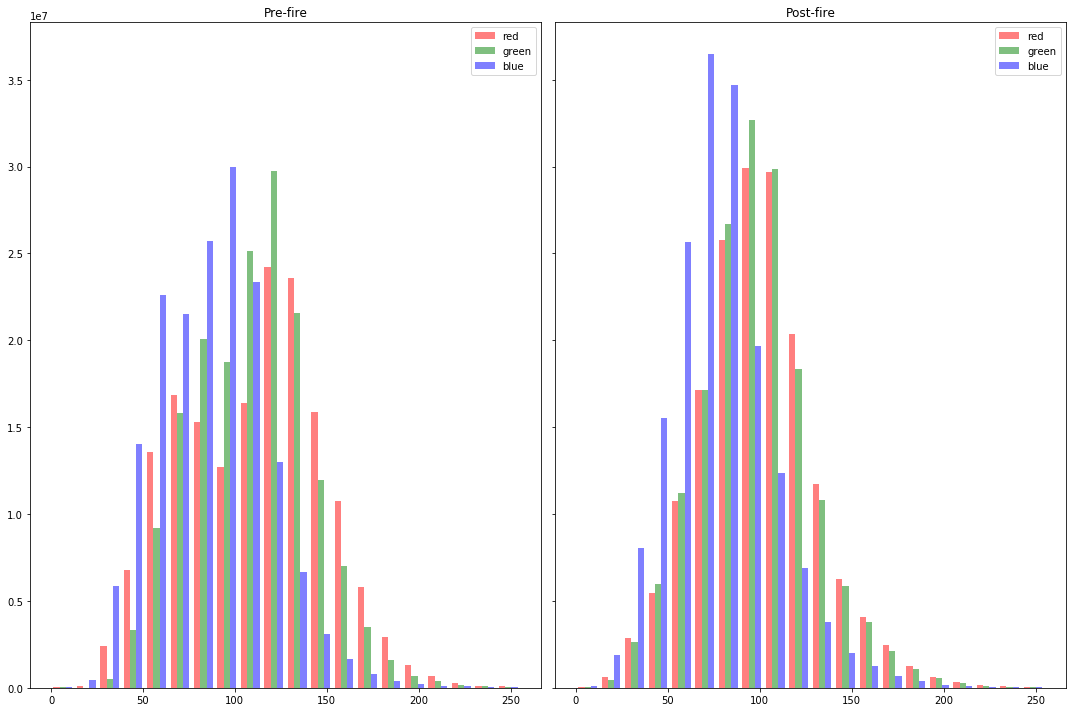

In [11]:
n_bins = 20
colors = ['red', 'green', 'blue']
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(15, 10))
axs[0].hist(x_pre, n_bins, alpha=0.5, color=colors, label=colors)
axs[1].hist(y_post, n_bins, alpha=0.5, color=colors, label=colors)
axs[0].legend(prop={'size': 10})
axs[1].legend(prop={'size': 10})
axs[0].set_title("Pre-fire")
axs[1].set_title("Post-fire")
plt.show()

# MinMax Histogram Stretch on Sent2 images

MinMax histogram stretch on values on Sent2 images. The maximum was determined in properties of pre-fire image. 
This is done since DigitalGlobe images were adjusted according to their Dynamic Range Adjustment (no specifics on how this histogram stretch is done). 

In [268]:
#command in gdal translate
#!gdal_translate -scale 0 7210 0 255 -ot Byte data/Paradise/post/B08_post_clipped.tif data/Paradise/post/B08_post_clipped_byte_scaled.tif

Input file size is 1490, 2279
0...10...20...30...40...50...60...70...80...90...100 - done.


In [269]:
#command in gdal translate
#!gdal_translate -scale 0 7210 0 255 -ot Byte data/Paradise/pre/B08_pre_clipped.tif data/Paradise/pre/B08_pre_clipped_byte_scaled.tif

Input file size is 1490, 2279
0...10...20...30...40...50...60...70...80...90...100 - done.


In [20]:
bbox_post = box(raster_src_post.bounds.left, raster_src_post.bounds.bottom, raster_src_post.bounds.right, raster_src_post.bounds.top)
bbox_pre = box(raster_src_pre.bounds.left, raster_src_pre.bounds.bottom, raster_src_pre.bounds.right, raster_src_pre.bounds.top)

In [28]:
out_img_post_b08, out_img_transform_post_b08, out_meta_post = clipImg(bbox_post, raster_src_post_b08, proj=4326)
out_img_pre_b08, out_img_transform_pre_b08 , out_meta_pre = clipImg(bbox_pre, raster_src_pre_b08, proj=4326)

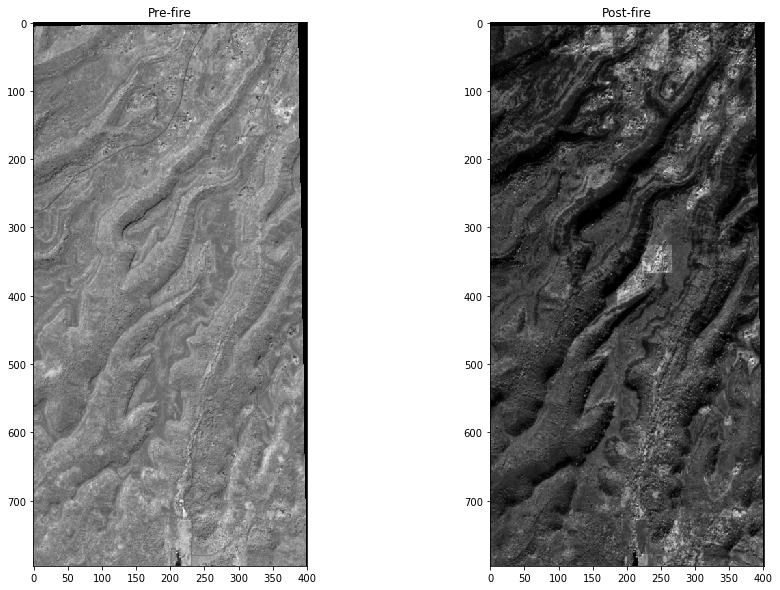

In [29]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 10))
im = ax1.imshow(out_img_pre_b08[0], cmap='gray')
ax1.set_title("Pre-fire")
im = ax2.imshow(out_img_post_b08[0], cmap='gray')
ax2.set_title("Post-fire")
plt.show()

In [30]:
x_nir_pre = out_img_pre_b08[0].ravel()
y_nir_post = out_img_post_b08[0].ravel()

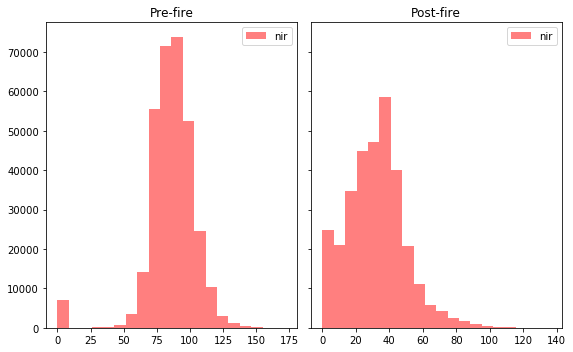

In [31]:
n_bins = 20
colors = ['red']
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(8, 5))
axs[0].hist(x_nir_pre, n_bins, alpha=0.5, color=colors, label='nir')
axs[1].hist(y_nir_post, n_bins, alpha=0.5, color=colors, label='nir')
axs[0].legend(prop={'size': 10})
axs[1].legend(prop={'size': 10})
axs[0].set_title("Pre-fire")
axs[1].set_title("Post-fire")
plt.show()

# Segment image

In [33]:
chunksize = (rgb_post.shape[0]//2, rgb_post.shape[1]//2)
chunksize

(8168, 5193)

In [36]:
from skimage.segmentation import slic, felzenszwalb
from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops
segments_slic = slic(rgb_pre[0:chunksize[0], 0:chunksize[1], :], n_segments=5000, compactness=10)
#segments_slic = np.add(np.ones(segments_slic.shape), segments_slic).astype(np.uint16)
print('SLIC number of segments: {}'.format(len(np.unique(segments_slic))))
#segments_fz = felzenszwalb(out_img_pre[0:chunksize[0], 0:chunksize[1], :], scale=10, sigma=0.5, min_size=20)
#print('Felz number of segments: {}'.format(len(np.unique(segments_fz))))

SLIC number of segments: 3432


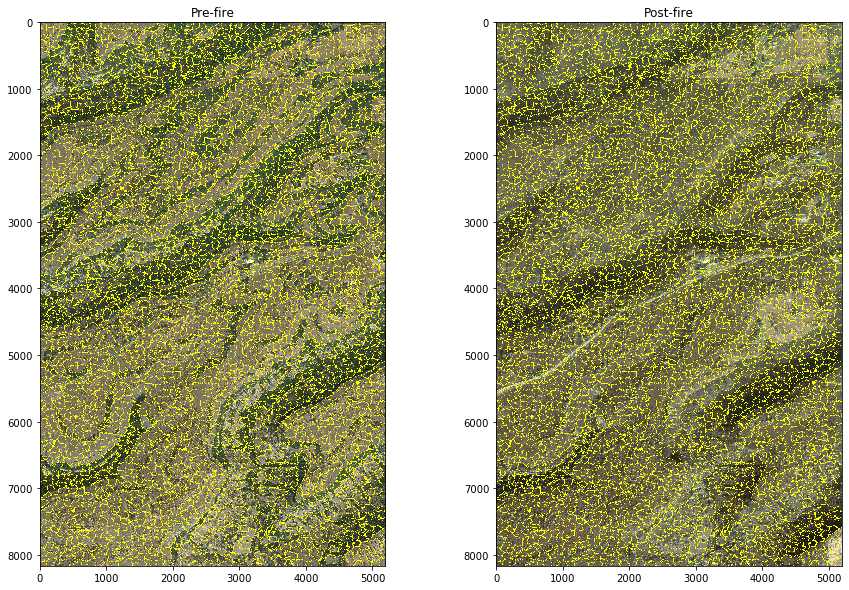

In [37]:
boundary_rgb_post = mark_boundaries(rgb_post[0:chunksize[0], 0:chunksize[1], :], segments_slic, outline_color=(1, 1, 0), mode='thick')
bouncary_rgb_pre = mark_boundaries(rgb_pre[0:chunksize[0], 0:chunksize[1], :], segments_slic, outline_color=(1, 1, 0), mode='thick')

#boundary_rgb_post = mark_boundaries(out_img_pre[0:chunksize[0], 0:chunksize[1], :], segments_fz, outline_color=(1, 1, 0), mode='thick')
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 10))
im = ax1.imshow(bouncary_rgb_pre)
ax1.set_title("Pre-fire")
im = ax2.imshow(boundary_rgb_post)
ax2.set_title("Post-fire")
plt.show()

# Vectorize segments with spectral vals

In [40]:
import shapely
from shapely.wkt import loads
from shapely.geometry import Polygon, mapping, shape, MultiPolygon, box
from rasterio import features
import geopandas as gpd
import pandas as pd

shapes_list = [{'seg_index': int(v), 'geometry': loads(shape(g).wkt)} for g, v in features.shapes(segments_slic.astype(np.uint16), mask=None, transform=raster_src_pre.transform)]
gdf = gpd.GeoDataFrame(shapes_list)
gdf.crs = {'init': 'EPSG:4326'}
gdf.insert(2, 'crs', str(raster_src_post.crs))
gdf.head()

,geometry,seg_index,crs
0,"POLYGON ((-121.6648281321806 39.7265625, -121....",39,EPSG:4326
1,"POLYGON ((-121.6657346837661 39.7265625, -121....",38,EPSG:4326
2,"POLYGON ((-121.673848769244 39.7265625, -121.6...",27,EPSG:4326
3,"POLYGON ((-121.6850460276884 39.7265625, -121....",5,EPSG:4326
4,"POLYGON ((-121.6867918126723 39.7265625, -121....",1,EPSG:4326


In [41]:
## use regionprops onn segments to extract properties for dataframe

#post
regions_red = regionprops(segments_slic, rgb_post[0:chunksize[0], 0:chunksize[1],0])
regions_blue = regionprops(segments_slic, rgb_post[0:chunksize[0], 0:chunksize[1],1])
regions_green = regionprops(segments_slic, rgb_post[0:chunksize[0], 0:chunksize[1],2])

#pre
regions_red_pre = regionprops(segments_slic, rgb_pre[0:chunksize[0], 0:chunksize[1],0])
regions_blue_pre = regionprops(segments_slic, rgb_pre[0:chunksize[0], 0:chunksize[1],1])
regions_green_pre = regionprops(segments_slic, rgb_pre[0:chunksize[0], 0:chunksize[1],2])

In [42]:
gdf = gdf[gdf['seg_index'] != 0]

In [43]:
project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'), # source coordinate system
    pyproj.Proj(init='epsg:32610')) # destination coordinate system

# g1 = gdf.loc[gdf['seg_index']==1000, 'geometry'].iloc[0]
# g2 = transform(project, g1)  # apply projection

In [44]:
# create a dataframe with spectral values as column names , index value "seg_index" for merging geodataframe with Polygons
region_spectrals = []
for i in range(len(regions_red)):
    seg_label = regions_red[i].label
    g1 = gdf.loc[gdf['seg_index']==seg_label, 'geometry'].iloc[0]
    g2 = transform(project, g1)
    
    nir_zone_post = zonal_stats(g2, out_img_post_b08[0], affine=out_img_transform_post_b08, stats='mean', nodata=-999)
    nir_zone_pre = zonal_stats(g2, out_img_pre_b08[0], affine=out_img_transform_pre_b08, stats='mean', nodata=-999)
    
    dict_seg = {'seg_index': regions_red[i].label, 
         'red_value': regions_red[i].mean_intensity, 
         'blue_value': regions_blue[i].mean_intensity, 
         'green_value': regions_green[i].mean_intensity, 
         'nir_value': nir_zone_post[0]['mean'],
         'red_value_pre': regions_red_pre[i].mean_intensity, 
         'blue_value_pre': regions_blue_pre[i].mean_intensity, 
         'green_value_pre': regions_green_pre[i].mean_intensity, 
         'nir_value_pre': nir_zone_pre[0]['mean'],
         'area_m': regions_red[i].area * 0.31} #area in meters
    region_spectrals.append(dict_seg)


In [46]:
df = pd.DataFrame(region_spectrals)
df.head()

,area_m,blue_value,blue_value_pre,green_value,green_value_pre,nir_value,nir_value_pre,red_value,red_value_pre,seg_index
0,3147.74,109.685346,116.452433,85.161710,92.393343,NaN,NaN,110.655604,122.922592,1
1,2811.39,114.283824,138.130996,89.265851,106.846400,36.000000,104.000000,115.912780,151.945860,2
2,3607.47,104.541119,127.709289,81.765747,103.572914,25.090909,81.909091,104.987969,132.850735,3
3,3068.69,90.751894,76.010607,70.956763,49.231741,17.909091,104.772727,89.023134,54.704920,4
4,4211.66,90.293832,77.478728,70.063963,51.295230,17.793103,104.310345,90.042617,57.097232,5


In [47]:
# merge on seg_index
gdf2 = pd.merge(gdf, df, on='seg_index')

# #add in these two columns for labelling later
# gdf2['land_class'] = np.nan
# gdf2['burn_class'] = np.nan
gdf2.head()

,geometry,seg_index,crs,area_m,blue_value,blue_value_pre,green_value,green_value_pre,nir_value,nir_value_pre,red_value,red_value_pre
0,"POLYGON ((-121.6648281321806 39.7265625, -121....",39,EPSG:4326,1835.51,106.071103,110.004729,80.867421,83.078365,32.818182,84.727273,100.653437,115.414119
1,"POLYGON ((-121.6657346837661 39.7265625, -121....",38,EPSG:4326,2846.11,95.255746,92.842828,71.205642,68.743056,19.500000,78.142857,89.922449,89.938024
2,"POLYGON ((-121.673848769244 39.7265625, -121.6...",27,EPSG:4326,1973.77,112.471651,103.313177,86.320402,79.770221,30.076923,80.692308,105.628082,100.183760
3,"POLYGON ((-121.6850460276884 39.7265625, -121....",5,EPSG:4326,4211.66,90.293832,77.478728,70.063963,51.295230,17.793103,104.310345,90.042617,57.097232
4,"POLYGON ((-121.6867918126723 39.7265625, -121....",1,EPSG:4326,3147.74,109.685346,116.452433,85.161710,92.393343,NaN,NaN,110.655604,122.922592


## Compute SIs
$$SI= \frac{Band_1-Band_2}{Band_1+Band_2}$$

$$\Delta SI= SI_{pre}-SI_{post}$$

In [48]:
def computeSI(b1, b2):
    return (b1-b2)/(b1+b2)

def changedSI(SI_pre, SI_post):
    return SI_pre - SI_post

In [49]:
# convert the keys to list
post_keys = ['blue_value', 'green_value', 'red_value', 'nir_value']
pre_keys = ['blue_value_pre', 'green_value_pre', 'red_value_pre', 'nir_value_pre']

In [50]:
perm = itertools.permutations(post_keys, 2)
perm_pre = itertools.permutations(pre_keys, 2)

In [51]:
post_SI_keys = []
for i, tup in enumerate(perm):
    b1 = tup[0]
    b2 = tup[1]
    col_name = "SI_" + b1[0] + b2[0] + "_post"
    post_SI_keys.append(col_name)
    print(col_name)
    gdf2[col_name] = computeSI(gdf2[b1], gdf2[b2])
gdf2.head()

SI_bg_post
SI_br_post
SI_bn_post
SI_gb_post
SI_gr_post
SI_gn_post
SI_rb_post
SI_rg_post
SI_rn_post
SI_nb_post
SI_ng_post
SI_nr_post


,geometry,seg_index,crs,area_m,blue_value,blue_value_pre,green_value,green_value_pre,nir_value,nir_value_pre,...,SI_bn_post,SI_gb_post,SI_gr_post,SI_gn_post,SI_rb_post,SI_rg_post,SI_rn_post,SI_nb_post,SI_ng_post,SI_nr_post
0,"POLYGON ((-121.6648281321806 39.7265625, -121....",39,EPSG:4326,1835.51,106.071103,110.004729,80.867421,83.078365,32.818182,84.727273,...,0.527420,-0.134823,-0.109001,0.422650,-0.026207,0.109001,0.508237,-0.527420,-0.422650,-0.508237
1,"POLYGON ((-121.6657346837661 39.7265625, -121....",38,EPSG:4326,2846.11,95.255746,92.842828,71.205642,68.743056,19.500000,78.142857,...,0.660148,-0.144479,-0.116161,0.570038,-0.028801,0.116161,0.643583,-0.660148,-0.570038,-0.643583
2,"POLYGON ((-121.673848769244 39.7265625, -121.6...",27,EPSG:4326,1973.77,112.471651,103.313177,86.320402,79.770221,30.076923,80.692308,...,0.578012,-0.131551,-0.100588,0.483203,-0.031378,0.100588,0.556731,-0.578012,-0.483203,-0.556731
3,"POLYGON ((-121.6850460276884 39.7265625, -121....",5,EPSG:4326,4211.66,90.293832,77.478728,70.063963,51.295230,17.793103,104.310345,...,0.670763,-0.126155,-0.124783,0.594953,-0.001393,0.124783,0.669996,-0.670763,-0.594953,-0.669996
4,"POLYGON ((-121.6867918126723 39.7265625, -121....",1,EPSG:4326,3147.74,109.685346,116.452433,85.161710,92.393343,NaN,NaN,...,NaN,-0.125861,-0.130192,NaN,0.004403,0.130192,NaN,NaN,NaN,NaN


In [52]:
pre_SI_keys = []
for i, tup in enumerate(perm_pre):
    b1 = tup[0]
    b2 = tup[1]
    col_name = "SI_" + b1[0] + b2[0] + "_pre"
    pre_SI_keys.append(col_name)
    print(col_name)
    gdf2[col_name] = computeSI(gdf2[b1], gdf2[b2])
gdf2.head()

SI_bg_pre
SI_br_pre
SI_bn_pre
SI_gb_pre
SI_gr_pre
SI_gn_pre
SI_rb_pre
SI_rg_pre
SI_rn_pre
SI_nb_pre
SI_ng_pre
SI_nr_pre


,geometry,seg_index,crs,area_m,blue_value,blue_value_pre,green_value,green_value_pre,nir_value,nir_value_pre,...,SI_bn_pre,SI_gb_pre,SI_gr_pre,SI_gn_pre,SI_rb_pre,SI_rg_pre,SI_rn_pre,SI_nb_pre,SI_ng_pre,SI_nr_pre
0,"POLYGON ((-121.6648281321806 39.7265625, -121....",39,EPSG:4326,1835.51,106.071103,110.004729,80.867421,83.078365,32.818182,84.727273,...,0.129806,-0.139455,-0.162907,-0.009826,0.023997,0.162907,0.153326,-0.129806,0.009826,-0.153326
1,"POLYGON ((-121.6657346837661 39.7265625, -121....",38,EPSG:4326,2846.11,95.255746,92.842828,71.205642,68.743056,19.500000,78.142857,...,0.085972,-0.149145,-0.133570,-0.063994,-0.015892,0.133570,0.070176,-0.085972,0.063994,-0.070176
2,"POLYGON ((-121.673848769244 39.7265625, -121.6...",27,EPSG:4326,1973.77,112.471651,103.313177,86.320402,79.770221,30.076923,80.692308,...,0.122936,-0.128591,-0.113438,-0.005746,-0.015378,0.113438,0.107761,-0.122936,0.005746,-0.107761
3,"POLYGON ((-121.6850460276884 39.7265625, -121....",5,EPSG:4326,4211.66,90.293832,77.478728,70.063963,51.295230,17.793103,104.310345,...,-0.147598,-0.203329,-0.053528,-0.340702,-0.151450,0.053528,-0.292509,0.147598,0.340702,0.292509
4,"POLYGON ((-121.6867918126723 39.7265625, -121....",1,EPSG:4326,3147.74,109.685346,116.452433,85.161710,92.393343,NaN,NaN,...,NaN,-0.115200,-0.141788,NaN,0.027029,0.141788,NaN,NaN,NaN,NaN


compute dSIs

In [53]:
SI_keys = pre_SI_keys + post_SI_keys
SI_keys

['SI_bg_pre',
 'SI_br_pre',
 'SI_bn_pre',
 'SI_gb_pre',
 'SI_gr_pre',
 'SI_gn_pre',
 'SI_rb_pre',
 'SI_rg_pre',
 'SI_rn_pre',
 'SI_nb_pre',
 'SI_ng_pre',
 'SI_nr_pre',
 'SI_bg_post',
 'SI_br_post',
 'SI_bn_post',
 'SI_gb_post',
 'SI_gr_post',
 'SI_gn_post',
 'SI_rb_post',
 'SI_rg_post',
 'SI_rn_post',
 'SI_nb_post',
 'SI_ng_post',
 'SI_nr_post']

In [54]:
band_combos = list(set([key.split('_')[1] for key in post_SI_keys]))
SI_combos = [ tuple([s for s in SI_keys if bcombostr in s]) for bcombostr in band_combos]
SI_combos

[('SI_nb_pre', 'SI_nb_post'),
 ('SI_nr_pre', 'SI_nr_post'),
 ('SI_gn_pre', 'SI_gn_post'),
 ('SI_bn_pre', 'SI_bn_post'),
 ('SI_bg_pre', 'SI_bg_post'),
 ('SI_rb_pre', 'SI_rb_post'),
 ('SI_br_pre', 'SI_br_post'),
 ('SI_gb_pre', 'SI_gb_post'),
 ('SI_rg_pre', 'SI_rg_post'),
 ('SI_ng_pre', 'SI_ng_post'),
 ('SI_gr_pre', 'SI_gr_post'),
 ('SI_rn_pre', 'SI_rn_post')]

In [55]:
# now, add dSIs to dataframe
for i, tup in enumerate(SI_combos):
    SI_post = tup[0]
    SI_pre = tup[1]
    col_name = "dSI_" + SI_post.split('_')[1]
    gdf2[col_name] = changedSI(gdf2[SI_pre], gdf2[SI_post])
gdf2.head()

,geometry,seg_index,crs,area_m,blue_value,blue_value_pre,green_value,green_value_pre,nir_value,nir_value_pre,...,dSI_gn,dSI_bn,dSI_bg,dSI_rb,dSI_br,dSI_gb,dSI_rg,dSI_ng,dSI_gr,dSI_rn
0,"POLYGON ((-121.6648281321806 39.7265625, -121....",39,EPSG:4326,1835.51,106.071103,110.004729,80.867421,83.078365,32.818182,84.727273,...,0.432476,0.397613,-0.004631,-0.050204,0.050204,0.004631,-0.053905,-0.432476,0.053905,0.354911
1,"POLYGON ((-121.6657346837661 39.7265625, -121....",38,EPSG:4326,2846.11,95.255746,92.842828,71.205642,68.743056,19.500000,78.142857,...,0.634032,0.574176,-0.004667,-0.012909,0.012909,0.004667,-0.017409,-0.634032,0.017409,0.573408
2,"POLYGON ((-121.673848769244 39.7265625, -121.6...",27,EPSG:4326,1973.77,112.471651,103.313177,86.320402,79.770221,30.076923,80.692308,...,0.488949,0.455076,0.002959,-0.016000,0.016000,-0.002959,-0.012850,-0.488949,0.012850,0.448969
3,"POLYGON ((-121.6850460276884 39.7265625, -121....",5,EPSG:4326,4211.66,90.293832,77.478728,70.063963,51.295230,17.793103,104.310345,...,0.935655,0.818361,-0.077175,0.150057,-0.150057,0.077175,0.071256,-0.935655,-0.071256,0.962505
4,"POLYGON ((-121.6867918126723 39.7265625, -121....",1,EPSG:4326,3147.74,109.685346,116.452433,85.161710,92.393343,NaN,NaN,...,NaN,NaN,0.010661,-0.022626,0.022626,-0.010661,-0.011596,NaN,0.011596,NaN


In [56]:
gdf2['land_class'] = np.nan
gdf2['burn_class'] = np.nan
gdf2.head()

,geometry,seg_index,crs,area_m,blue_value,blue_value_pre,green_value,green_value_pre,nir_value,nir_value_pre,...,dSI_bg,dSI_rb,dSI_br,dSI_gb,dSI_rg,dSI_ng,dSI_gr,dSI_rn,land_class,burn_class
0,"POLYGON ((-121.6648281321806 39.7265625, -121....",39,EPSG:4326,1835.51,106.071103,110.004729,80.867421,83.078365,32.818182,84.727273,...,-0.004631,-0.050204,0.050204,0.004631,-0.053905,-0.432476,0.053905,0.354911,NaN,NaN
1,"POLYGON ((-121.6657346837661 39.7265625, -121....",38,EPSG:4326,2846.11,95.255746,92.842828,71.205642,68.743056,19.500000,78.142857,...,-0.004667,-0.012909,0.012909,0.004667,-0.017409,-0.634032,0.017409,0.573408,NaN,NaN
2,"POLYGON ((-121.673848769244 39.7265625, -121.6...",27,EPSG:4326,1973.77,112.471651,103.313177,86.320402,79.770221,30.076923,80.692308,...,0.002959,-0.016000,0.016000,-0.002959,-0.012850,-0.488949,0.012850,0.448969,NaN,NaN
3,"POLYGON ((-121.6850460276884 39.7265625, -121....",5,EPSG:4326,4211.66,90.293832,77.478728,70.063963,51.295230,17.793103,104.310345,...,-0.077175,0.150057,-0.150057,0.077175,0.071256,-0.935655,-0.071256,0.962505,NaN,NaN
4,"POLYGON ((-121.6867918126723 39.7265625, -121....",1,EPSG:4326,3147.74,109.685346,116.452433,85.161710,92.393343,NaN,NaN,...,0.010661,-0.022626,0.022626,-0.010661,-0.011596,NaN,0.011596,NaN,NaN,NaN


In [57]:
gdf2.to_file("./data/segments.geojson", driver='GeoJSON')

# write data to files

In [19]:
writeDatasets(fps_wv_post[8:], fps_wv_pre[8:], fp_sent2_post, fp_sent2_pre)

Writing to data...
data\Paradise\post\2011203_post_clip.tif
reading clipped rgb images for 2011203
reading and clipping sent2 images
chunk image
starting segmentation for chunk 0
SLIC number of segments: 2693
vectorizing...
adding SIs to gdf
writing to destination: ./data/segments_2011203_0.geojson
starting segmentation for chunk 1
SLIC number of segments: 1919
vectorizing...
adding SIs to gdf
writing to destination: ./data/segments_2011203_1.geojson
starting segmentation for chunk 2
SLIC number of segments: 2251
vectorizing...
adding SIs to gdf
writing to destination: ./data/segments_2011203_2.geojson
starting segmentation for chunk 3
SLIC number of segments: 2083
vectorizing...
adding SIs to gdf
writing to destination: ./data/segments_2011203_3.geojson
